# ScreenMind — Milestone 3: Feature Engineering & Preprocessing

**Goal:** Turn the cleaned BRFSS 2024 dataframe into train/val/test splits
that PyTorch can consume in Milestone 4.

Steps:
1. Reload and re-clean the raw data (same logic as M2)
2. Define the feature matrix X and both targets (regression + classification)
3. Handle missing values via median imputation
4. Stratified 70/15/15 train/val/test split
5. Standardize features (StandardScaler fit only on train)
6. Save all arrays + scaler to `data/processed/`

---
**Key concepts introduced here:**
- Feature selection and why we exclude certain columns (data leakage)
- Why we impute (NaNs break neural nets) and why median works
- What stratified splitting guarantees
- What StandardScaler does and the train-only fitting rule

## 1. Imports & Constants

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')

# ── Paths ─────────────────────────────────────────────────────────────────────
RAW_DATA_PATH   = '../data/raw/LLCP2024.XPT'
PROCESSED_DIR   = Path('../data/processed')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# ── Reproducibility ───────────────────────────────────────────────────────────
RANDOM_SEED = 42

# ── Feature columns (predictor selection — see Section 3 for the WHY) ────────
#
# NOT included:
#   MENTHLTH   ← this IS the target; can't use as input
#   _MENT14D   ← CDC's own re-encoding of MENTHLTH; pure data leakage
#   high_risk  ← we derive this from MENTHLTH; same leakage problem
#   POORHLTH   ← "days poor health limited activities" is so correlated
#               with MENTHLTH that it dominates all other signal
#
FEATURE_COLS = [
    'PHYSHLTH',   # physical health days (0-30)
    'GENHLTH',    # self-rated general health (1=excellent, 5=poor)
    'ADDEPEV3',   # depression diagnosis history (0=No, 1=Yes)
    'LSATISFY',   # life satisfaction (1=very satisfied, 4=very dissatisfied)
    'EMTSUPRT',   # emotional support (1=always, 5=never)
    'SDLONELY',   # loneliness (1=always, 5=never)
    'SDHBILLS',   # hard to pay bills (0=No, 1=Yes)
    'EXERANY2',   # any exercise past 30 days (0=No, 1=Yes)
    'SMOKE100',   # ever smoked ≥100 cigarettes (0=No, 1=Yes)
    'SEXVAR',     # sex (0=Female, 1=Male)
    'EMPLOY1',    # employment status (1-8 categories)
    'INCOME3',    # household income (1-11 categories)
    'EDUCA',      # education level (1-6 categories)
    '_AGEG5YR',   # age in 5-year bands (1-13)
    '_BMI5CAT',   # BMI category (1=Underweight, 4=Obese)
]

TARGET_REG = 'MENTHLTH'   # regression: predict continuous days (0-30)
TARGET_CLF = 'high_risk'  # classification: predict binary high-risk (>14 days)

print(f'Feature columns: {len(FEATURE_COLS)}')
print(f'Processed output directory: {PROCESSED_DIR.resolve()}')

Feature columns: 15
Processed output directory: C:\Users\zinge\coding_projects\ScreenTimeML\data\processed


## 2. Reload & Re-clean Raw Data

We repeat the cleaning logic from M2 here so this notebook is self-contained.
In Milestone 4, the training script will import `src/data/preprocessing.py` instead.

In [2]:
ALL_COLS = FEATURE_COLS + ['MENTHLTH', '_MENT14D', 'POORHLTH']

print('Loading BRFSS 2024 data (1–3 minutes)...')
df_raw = pd.read_sas(RAW_DATA_PATH, encoding='latin-1')

available = [c for c in ALL_COLS if c in df_raw.columns]
df = df_raw[available].copy()
print(f'Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')

# ── Sentinel code cleaning (same as M2) ───────────────────────────────────────

def clean_days(s):   return s.replace(88, 0).replace([77, 99], np.nan)
def clean_binary(s): return s.replace(2, 0).replace([7, 9], np.nan)
def clean_scale(s):  return s.replace([7, 9], np.nan)

for col in ['MENTHLTH', 'PHYSHLTH', 'POORHLTH']:
    if col in df.columns:
        df[col] = clean_days(df[col])

df['GENHLTH'] = clean_scale(df['GENHLTH'])

for col in ['ADDEPEV3', 'EXERANY2', 'SMOKE100', 'SDHBILLS']:
    if col in df.columns:
        df[col] = clean_binary(df[col])

if 'SEXVAR' in df.columns:
    df['SEXVAR'] = df['SEXVAR'].replace(2, 0)  # 1=Male, 0=Female

for col in ['LSATISFY', 'EMTSUPRT', 'SDLONELY']:
    if col in df.columns:
        df[col] = clean_scale(df[col])

for col in ['EMPLOY1', 'INCOME3', 'EDUCA']:
    if col in df.columns:
        df[col] = df[col].replace([77, 99, 7, 9], np.nan)

if '_AGEG5YR' in df.columns:
    df['_AGEG5YR'] = df['_AGEG5YR'].replace(14, np.nan)

if '_MENT14D' in df.columns:
    df['_MENT14D'] = df['_MENT14D'].replace(9, np.nan)

# ── Derive classification target ──────────────────────────────────────────────
df['high_risk'] = np.where(
    df['MENTHLTH'].isna(), np.nan,
    (df['MENTHLTH'] > 14).astype(float)
)

print('Cleaning complete.')
print(f'MENTHLTH range: {df["MENTHLTH"].min():.0f}–{df["MENTHLTH"].max():.0f}')

Loading BRFSS 2024 data (1–3 minutes)...
Loaded: 457,670 rows × 18 columns
Cleaning complete.
MENTHLTH range: 0–30


## 3. Define Feature Matrix X and Targets y

### Why these columns and not others?

We exclude four columns that would cause **data leakage** — a subtle but critical error:

| Column | Why excluded |
|--------|--------------|
| `MENTHLTH` | *Is* the regression target — using it as input is circular |
| `_MENT14D` | The CDC re-encoded `MENTHLTH` as a 3-class variable; using it gives the model free answer access |
| `high_risk` | We derived this from `MENTHLTH`; same circular problem |
| `POORHLTH` | "Days poor health limited activities" — too correlated with MENTHLTH; would drown all other features |

This leaves 15 clean predictors covering physical health, psychosocial wellbeing,
social determinants, lifestyle behaviors, and demographics.

In [3]:
# Drop rows where the TARGET is NaN — we can't train on unknown labels
# (rows where a respondent refused to answer the mental health question entirely)
mask = df['MENTHLTH'].notna() & df['high_risk'].notna()
df_clean = df[mask].reset_index(drop=True)

print(f'Rows with valid target: {len(df_clean):,}  '
      f'(dropped {len(df) - len(df_clean):,} rows with missing target)')

# Feature matrix (rows × 15 features)
X = df_clean[FEATURE_COLS].copy()

# Regression target: continuous 0-30
y_reg = df_clean[TARGET_REG].values.astype(np.float32)

# Classification target: binary 0/1
y_clf = df_clean[TARGET_CLF].values.astype(np.float32)

print(f'\nFeature matrix X:  {X.shape[0]:,} rows × {X.shape[1]} columns')
print(f'y_reg (days):       min={y_reg.min():.0f}, max={y_reg.max():.0f}, mean={y_reg.mean():.2f}')
print(f'y_clf (binary):     {y_clf.mean()*100:.1f}% high-risk')

Rows with valid target: 449,514  (dropped 8,156 rows with missing target)

Feature matrix X:  449,514 rows × 15 columns
y_reg (days):       min=0, max=30, mean=4.41
y_clf (binary):     13.2% high-risk


## 4. Missing Value Analysis → Median Imputation

### Why we must impute

Neural networks compute: `output = activation(W · x + b)`

If any element of `x` is `NaN`, the entire dot product becomes `NaN`, and the whole
forward pass fails. Every row must have a valid number in every column.

### Why median (not mean)

Our BRFSS columns are **ordinal and often skewed**. The median is the 50th percentile —
robust to the extreme values that skew the mean. For example, PHYSHLTH has 60% zeros
but a few respondents with 30 days; the median is 0 but the mean is pulled upward.

### The train-only fitting rule

We fit the imputer on train data only. If we fit on the full dataset first, the imputer
learns median values that include test-set rows — that's subtle leakage. The pipeline:
`imputer.fit(X_train) → imputer.transform(X_train, X_val, X_test)`

In [4]:
missing_pct = (X.isna().mean() * 100).sort_values(ascending=False).round(2)
print('Missing (%) per feature column:')
print(missing_pct[missing_pct > 0].to_string())
print(f'\nColumns with no missing values: {(missing_pct == 0).sum()}')
print(f'Total missing cells: {X.isna().sum().sum():,} '
      f'/ {X.shape[0] * X.shape[1]:,} = {X.isna().mean().mean()*100:.2f}% of all cells')

Missing (%) per feature column:
EMTSUPRT    56.07
SDHBILLS    55.92
LSATISFY    55.79
SDLONELY    55.76
INCOME3     44.41
EMPLOY1     33.83
_BMI5CAT     9.24
SMOKE100     6.80
PHYSHLTH     1.92
_AGEG5YR     1.76
ADDEPEV3     0.50
EDUCA        0.47
EXERANY2     0.24
GENHLTH      0.24

Columns with no missing values: 1
Total missing cells: 1,451,633 / 6,742,710 = 21.53% of all cells


## 5. Train / Validation / Test Split (Stratified 70 / 15 / 15)

### Why 70/15/15?

With 449k rows, even 15% is ~67k examples — plenty for stable, low-variance estimates.
The 70% train set gives the model ~314k examples to learn from.

### What "stratified" means

Our dataset has a **class imbalance**: only 13.2% of respondents are high-risk.
A naïve random split could give 11% in one set and 15% in another by chance.
That would be a problem:
- The model trains on fewer hard cases than it should
- Evaluation metrics would be measured on a different distribution than training

**Stratified splitting** partitions the data *within each class separately*, then combines.
It guarantees that every split has the same 13.2% / 86.8% ratio.

We stratify on `y_clf` (the binary high_risk label), which naturally preserves balance
for both the classification and regression tasks.

### Two-step split
scikit-learn's `train_test_split` splits into exactly 2 sets. To get 3, we split twice:
1. `full → train (70%) + temp (30%)`
2. `temp → val (15%) + test (15%)`

In [5]:
X_arr = X.values.astype(np.float32)  # numpy array for sklearn

# Step 1: 70% train, 30% temp
X_train, X_temp, y_reg_train, y_reg_temp, y_clf_train, y_clf_temp = train_test_split(
    X_arr, y_reg, y_clf,
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=y_clf           # ← preserves the 13.2% high-risk ratio
)

# Step 2: split temp 50/50 → 15% val, 15% test
X_val, X_test, y_reg_val, y_reg_test, y_clf_val, y_clf_test = train_test_split(
    X_temp, y_reg_temp, y_clf_temp,
    test_size=0.50,
    random_state=RANDOM_SEED,
    stratify=y_clf_temp
)

print('Split sizes:')
print(f'  Train: {X_train.shape[0]:>7,} rows  ({X_train.shape[0]/len(X_arr)*100:.1f}%)')
print(f'  Val:   {X_val.shape[0]:>7,} rows  ({X_val.shape[0]/len(X_arr)*100:.1f}%)')
print(f'  Test:  {X_test.shape[0]:>7,} rows  ({X_test.shape[0]/len(X_arr)*100:.1f}%)')
print()
print('Class balance verification (high-risk %):')
print(f'  Full dataset: {y_clf.mean()*100:.2f}%')
print(f'  Train:        {y_clf_train.mean()*100:.2f}%')
print(f'  Val:          {y_clf_val.mean()*100:.2f}%')
print(f'  Test:         {y_clf_test.mean()*100:.2f}%')
print('  → All splits should be within ~0.01% of each other (stratification worked)')

Split sizes:
  Train: 314,659 rows  (70.0%)
  Val:    67,427 rows  (15.0%)
  Test:   67,428 rows  (15.0%)

Class balance verification (high-risk %):
  Full dataset: 13.23%
  Train:        13.23%
  Val:          13.23%
  Test:         13.23%
  → All splits should be within ~0.01% of each other (stratification worked)


## 6. Median Imputation (fit on train, apply to all)

Now that we have our splits, we can safely fit the imputer on train-only
and apply it to val and test without any data leakage.

In [6]:
imputer = SimpleImputer(strategy='median')

# fit_transform on train: learns medians from train, fills train NaNs
X_train = imputer.fit_transform(X_train)

# transform only on val/test: uses the medians learned from train
X_val  = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Verify no NaNs remain
print('NaN counts after imputation:')
print(f'  Train: {np.isnan(X_train).sum()}')
print(f'  Val:   {np.isnan(X_val).sum()}')
print(f'  Test:  {np.isnan(X_test).sum()}')
print('  → All zeros = imputation complete')
print()
print('Medians learned from train (used to fill NaNs in val/test):')
for col, med in zip(FEATURE_COLS, imputer.statistics_):
    print(f'  {col:<12} median = {med:.1f}')

NaN counts after imputation:
  Train: 0
  Val:   0
  Test:  0
  → All zeros = imputation complete

Medians learned from train (used to fill NaNs in val/test):
  PHYSHLTH     median = 0.0
  GENHLTH      median = 3.0
  ADDEPEV3     median = 0.0
  LSATISFY     median = 2.0
  EMTSUPRT     median = 2.0
  SDLONELY     median = 4.0
  SDHBILLS     median = 0.0
  EXERANY2     median = 1.0
  SMOKE100     median = 0.0
  SEXVAR       median = 0.0
  EMPLOY1      median = 1.0
  INCOME3      median = 6.0
  EDUCA        median = 5.0
  _AGEG5YR     median = 8.0
  _BMI5CAT     median = 3.0


## 7. StandardScaler (fit on train, apply to all)

### Why scale?

Consider two features in our dataset:
- `SEXVAR`: values are 0 or 1
- `PHYSHLTH`: values are 0 to 30

When the network computes `W · x`, the gradient for `PHYSHLTH` weights will be
30× larger in magnitude — not because physical health is 30× more important,
but purely because of scale. Training becomes slow and can fail.

### What StandardScaler does

For each feature column, it computes the training mean `μ` and std `σ`, then:
```
z = (x - μ) / σ
```
After scaling every feature has **mean ≈ 0 and std ≈ 1** in the training set.
The network can now treat all features on equal footing, and gradient descent
is numerically stable.

### Same rule as imputation: fit only on train

The scaler learns μ and σ from train data only. If we scaled the entire dataset
first, the scaler would know the mean of the test set — a form of data leakage.

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)   # learn μ, σ from train; scale train
X_val   = scaler.transform(X_val)          # apply train's μ, σ to val
X_test  = scaler.transform(X_test)         # apply train's μ, σ to test

print('Feature statistics after scaling (train set):')
print(f'{"Feature":<12}  {"mean":>8}  {"std":>8}  {"min":>8}  {"max":>8}')
print('-' * 50)
for i, col in enumerate(FEATURE_COLS):
    print(f'{col:<12}  {X_train[:, i].mean():8.4f}  {X_train[:, i].std():8.4f}  '
          f'{X_train[:, i].min():8.4f}  {X_train[:, i].max():8.4f}')
print()
print('Mean should be ≈ 0.0000 and std should be ≈ 1.0000 for all columns.')

Feature statistics after scaling (train set):
Feature           mean       std       min       max
--------------------------------------------------
PHYSHLTH        0.0000    1.0000   -0.5083    2.8923
GENHLTH        -0.0000    1.0000   -1.5677    2.2602
ADDEPEV3        0.0000    1.0000   -0.5145    1.9437
LSATISFY        0.0000    1.0000   -1.8075    4.7335
EMTSUPRT       -0.0000    1.0000   -1.3203    4.3143
SDLONELY        0.0000    1.0000   -4.5715    1.5181
SDHBILLS       -0.0000    1.0000   -0.2054    4.8693
EXERANY2       -0.0000    1.0000   -1.8309    0.5462
SMOKE100       -0.0000    1.0000   -0.7582    1.3188
SEXVAR          0.0000    1.0000   -0.9527    1.0497
EMPLOY1        -0.0000    1.0000   -0.4603    3.1702
INCOME3        -0.0000    1.0000   -2.5427    2.2300
EDUCA          -0.0000    1.0000   -3.9937    0.9579
_AGEG5YR        0.0000    1.0000   -1.8312    1.4662
_BMI5CAT       -0.0000    1.0000   -2.5225    1.2447

Mean should be ≈ 0.0000 and std should be ≈ 1.0000 for

### Visualize: before vs. after scaling (PHYSHLTH as example)

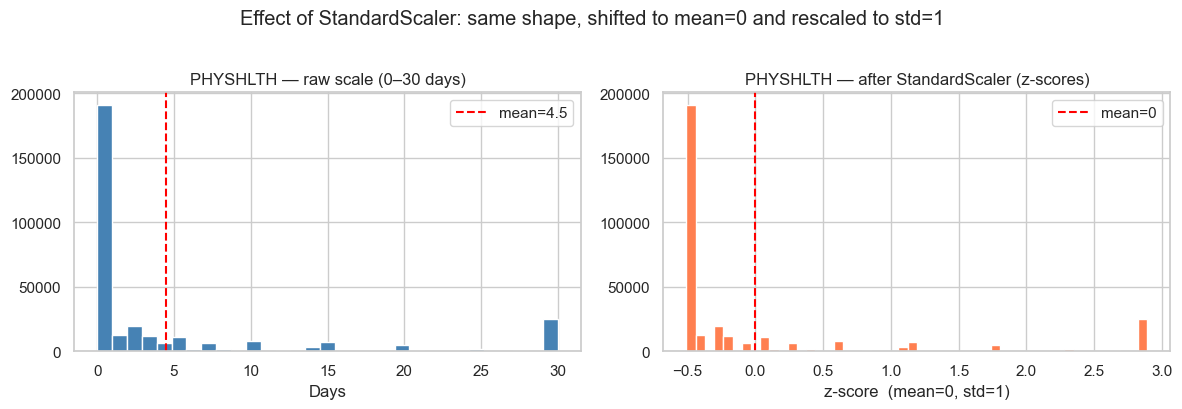

In [8]:
physhlth_idx = FEATURE_COLS.index('PHYSHLTH')

# Re-load raw PHYSHLTH from train before scaling for comparison
# (we already scaled X_train in place, so we use scaler to invert)
raw_vals = X_train[:, physhlth_idx] * scaler.scale_[physhlth_idx] + scaler.mean_[physhlth_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(raw_vals, bins=31, color='steelblue', edgecolor='white')
axes[0].set_title('PHYSHLTH — raw scale (0–30 days)')
axes[0].set_xlabel('Days')
axes[0].axvline(raw_vals.mean(), color='red', linestyle='--', label=f'mean={raw_vals.mean():.1f}')
axes[0].legend()

axes[1].hist(X_train[:, physhlth_idx], bins=50, color='coral', edgecolor='white')
axes[1].set_title('PHYSHLTH — after StandardScaler (z-scores)')
axes[1].set_xlabel('z-score  (mean=0, std=1)')
axes[1].axvline(0, color='red', linestyle='--', label='mean=0')
axes[1].legend()

plt.suptitle('Effect of StandardScaler: same shape, shifted to mean=0 and rescaled to std=1', y=1.02)
plt.tight_layout()
plt.show()

## 8. Save Processed Splits

We save:
- **Feature arrays** as `.npy` files — fast binary format for numpy/PyTorch
- **Target arrays** (both regression and classification) as `.npy` files
- **Scaler** as `.pkl` via joblib — so we can re-apply the exact same transformation
  at inference time in the FastAPI app (Milestone 8)

In [9]:
# ── Feature arrays ─────────────────────────────────────────────────────────────
np.save(PROCESSED_DIR / 'X_train.npy', X_train)
np.save(PROCESSED_DIR / 'X_val.npy',   X_val)
np.save(PROCESSED_DIR / 'X_test.npy',  X_test)

# ── Regression targets (continuous 0-30) ───────────────────────────────────────
np.save(PROCESSED_DIR / 'y_reg_train.npy', y_reg_train)
np.save(PROCESSED_DIR / 'y_reg_val.npy',   y_reg_val)
np.save(PROCESSED_DIR / 'y_reg_test.npy',  y_reg_test)

# ── Classification targets (binary 0/1) ────────────────────────────────────────
np.save(PROCESSED_DIR / 'y_clf_train.npy', y_clf_train)
np.save(PROCESSED_DIR / 'y_clf_val.npy',   y_clf_val)
np.save(PROCESSED_DIR / 'y_clf_test.npy',  y_clf_test)

# ── Scaler (needed to transform new data at inference time) ───────────────────
joblib.dump(scaler,   PROCESSED_DIR / 'scaler.pkl')
joblib.dump(imputer,  PROCESSED_DIR / 'imputer.pkl')

# ── Save feature column list for reference ────────────────────────────────────
import json
(PROCESSED_DIR / 'feature_cols.json').write_text(json.dumps(FEATURE_COLS, indent=2))

print('Saved to data/processed/:')
for f in sorted(PROCESSED_DIR.iterdir()):
    size_kb = f.stat().st_size / 1024
    print(f'  {f.name:<25} {size_kb:>8.1f} KB')

Saved to data/processed/:
  .gitkeep                       0.0 KB
  feature_cols.json              0.2 KB
  imputer.pkl                    0.5 KB
  scaler.pkl                     0.9 KB
  X_test.npy                  3951.0 KB
  X_train.npy                18437.2 KB
  X_val.npy                   3950.9 KB
  y_clf_test.npy               263.5 KB
  y_clf_train.npy             1229.3 KB
  y_clf_val.npy                263.5 KB
  y_reg_test.npy               263.5 KB
  y_reg_train.npy             1229.3 KB
  y_reg_val.npy                263.5 KB


## 9. Milestone 3 Summary

In [10]:
print('=' * 65)
print('MILESTONE 3 SUMMARY — Feature Engineering & Preprocessing')
print('=' * 65)
print()
print('INPUT:   457,670 raw BRFSS 2024 respondents')
print(f'USABLE:  {len(X_arr):,} rows with valid MENTHLTH target')
print(f'FEATURES: {len(FEATURE_COLS)} predictors')
print()
print('SPLITS:')
print(f'  Train  {X_train.shape[0]:>7,} × {X_train.shape[1]}   (70%)')
print(f'  Val    {X_val.shape[0]:>7,} × {X_val.shape[1]}   (15%)')
print(f'  Test   {X_test.shape[0]:>7,} × {X_test.shape[1]}   (15%)')
print()
print('CLASS BALANCE (high-risk %) — stratification verified:')
print(f'  Train {y_clf_train.mean()*100:.2f}%  |  Val {y_clf_val.mean()*100:.2f}%  |  Test {y_clf_test.mean()*100:.2f}%')
print()
print('PREPROCESSING PIPELINE:')
print('  1. Sentinel code removal (88→0, 77/99→NaN)')
print('  2. Drop rows with missing MENTHLTH target')
print('  3. Median imputation for feature NaNs (fit on train only)')
print('  4. StandardScaler normalization (fit on train only)')
print()
print('ARTIFACTS SAVED to data/processed/:')
print('  X_train/val/test.npy    — scaled feature arrays')
print('  y_reg_train/val/test.npy — continuous MENTHLTH (0-30)')
print('  y_clf_train/val/test.npy — binary high_risk (0/1)')
print('  scaler.pkl, imputer.pkl  — for inference-time preprocessing')
print('  feature_cols.json        — column ordering reference')
print()
print('NEXT: Milestone 4 — PyTorch Dataset, DataLoader, MLP, training loop')

MILESTONE 3 SUMMARY — Feature Engineering & Preprocessing

INPUT:   457,670 raw BRFSS 2024 respondents
USABLE:  449,514 rows with valid MENTHLTH target
FEATURES: 15 predictors

SPLITS:
  Train  314,659 × 15   (70%)
  Val     67,427 × 15   (15%)
  Test    67,428 × 15   (15%)

CLASS BALANCE (high-risk %) — stratification verified:
  Train 13.23%  |  Val 13.23%  |  Test 13.23%

PREPROCESSING PIPELINE:
  1. Sentinel code removal (88→0, 77/99→NaN)
  2. Drop rows with missing MENTHLTH target
  3. Median imputation for feature NaNs (fit on train only)
  4. StandardScaler normalization (fit on train only)

ARTIFACTS SAVED to data/processed/:
  X_train/val/test.npy    — scaled feature arrays
  y_reg_train/val/test.npy — continuous MENTHLTH (0-30)
  y_clf_train/val/test.npy — binary high_risk (0/1)
  scaler.pkl, imputer.pkl  — for inference-time preprocessing
  feature_cols.json        — column ordering reference

NEXT: Milestone 4 — PyTorch Dataset, DataLoader, MLP, training loop
